In [9]:
import os
import re
from pathlib import Path

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns

In [10]:
figdir = '../results/figures/marker_deconvolution_11032020'
Path(figdir).mkdir(parents=True, exist_ok=True)
sc.settings.figdir = figdir

## ductal cell clustering

In [11]:
adata = sc.read_h5ad('../results/cytotrace/eus_adata_11032020.h5ad')
adata

AnnData object with n_obs × n_vars = 11030 × 2923
    obs: 'sample_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'cytotrace'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'gene_ids-10', 'feature_types-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'feature_types-7', 'gene_ids-8', 'feature_types-8', 'gene_ids-9', 'feature_types-9', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden', 

In [19]:
tumor = adata[((adata.obs['cell_type']=='malignant_classical') | (adata.obs['cell_type']=='malignant_squamous_like'))].copy()
tumor


AnnData object with n_obs × n_vars = 1847 × 2923
    obs: 'sample_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'cytotrace'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'gene_ids-10', 'feature_types-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'feature_types-7', 'gene_ids-8', 'feature_types-8', 'gene_ids-9', 'feature_types-9', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden', '

In [5]:
# sc.pp.pca(tumor, n_comps=30)
# sc.pp.neighbors(tumor, n_neighbors=10, n_pcs=30)
# sc.tl.umap(tumor)

In [6]:
# sc.pl.umap(tumor, color=['sample_id', 'cytotrace', 'cell_type'], wspace=.2, ncols=2)

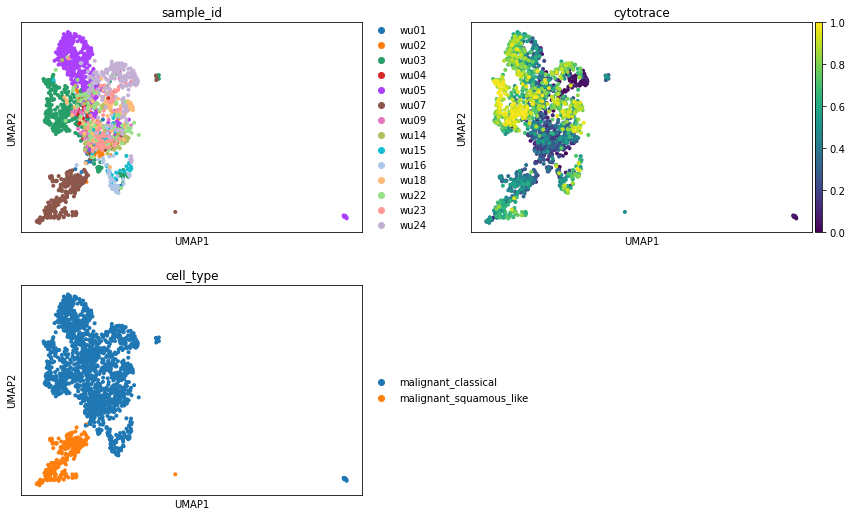

In [7]:
sc.pl.umap(tumor, color=['sample_id', 'cytotrace', 'cell_type'], wspace=.2, ncols=2)

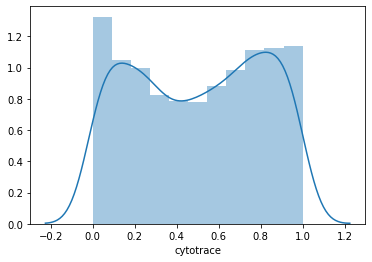

In [8]:
sns.distplot(tumor[tumor.obs['cell_type']=='malignant_classical'].obs['cytotrace'])

In [9]:
tumor.obs['status'] = ['ED' if x > .41 else 'LD'
                      for x in tumor.obs['cytotrace']]

In [10]:
tumor.obs['ductal_subtype'] = ['Squamous-like' if ct == 'malignant_squamous_like' else f'Classical'
                              for ct, subtype in zip(tumor.obs['cell_type'], tumor.obs['status'])]

... storing 'status' as categorical
... storing 'ductal_subtype' as categorical


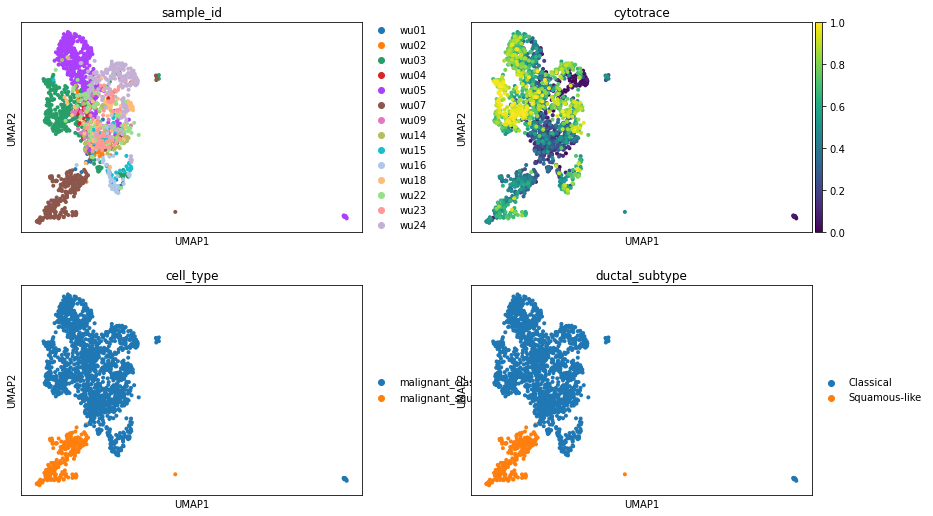

In [11]:
sc.pl.umap(tumor, color=['sample_id', 'cytotrace', 'cell_type', 'ductal_subtype'], wspace=.2, ncols=2)

In [16]:
## load in correlations
cytotrace_correlations = pd.read_csv('../results/cytotrace/eus_classical_only_11032020_gene_correlations.txt',
                                     sep='\t', header=None)
cytotrace_correlations.columns = ['gene', 'cytotrace_correlation']
cytotrace_correlations = cytotrace_correlations.set_index('gene')
cytotrace_correlations.index.name = 'gene'
cytotrace_correlations

,cytotrace_correlation
gene,
FAM87B,0.021911
LINC00115,0.018774
FAM41C,0.022186
SAMD11,0.025151
NOC2L,0.239765
...,...
AC007325.4,0.031398
AC007325.2,-0.025482
AL354822.1,-0.040488


In [17]:
list(cytotrace_correlations.index)[:20]

['FAM87B',
 'LINC00115',
 'FAM41C',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'UBE2J2',
 'SCNN1D']

In [20]:
gene_to_corr = {g:c for g, c in zip(cytotrace_correlations.index, cytotrace_correlations['cytotrace_correlation'])}
tumor.var['cytotrace_correlation'] = [gene_to_corr.get(g) for g in tumor.var.index]
tumor.var

,gene_ids-0,feature_types-0,gene_ids-1,gene_ids-10,feature_types-10,gene_ids-11,feature_types-11,gene_ids-12,feature_types-12,gene_ids-13,...,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std,cytotrace_correlation
ISG15,ENSG00000187608,Gene Expression,ENSG00000187608,ENSG00000187608,Gene Expression,ENSG00000187608,Gene Expression,ENSG00000187608,Gene Expression,ENSG00000187608,...,0.862118,76.540108,15100.0,True,0.979186,3.170052,0.907037,1.387907e-10,0.798031,0.377928
RNF223,ENSG00000237330,Gene Expression,ENSG00000237330,ENSG00000237330,Gene Expression,ENSG00000237330,Gene Expression,ENSG00000237330,Gene Expression,ENSG00000237330,...,0.015244,98.818156,267.0,True,0.015967,2.879332,1.119014,-2.443729e-11,0.086619,0.096223
TNFRSF18,ENSG00000186891,Gene Expression,ENSG00000186891,ENSG00000186891,Gene Expression,ENSG00000186891,Gene Expression,ENSG00000186891,Gene Expression,ENSG00000186891,...,0.042250,97.607765,740.0,True,0.123177,2.469263,0.652352,-3.563174e-11,0.264237,0.029630
TNFRSF4,ENSG00000186827,Gene Expression,ENSG00000186827,ENSG00000186827,Gene Expression,ENSG00000186827,Gene Expression,ENSG00000186827,Gene Expression,ENSG00000186827,...,0.051613,96.939766,904.0,True,0.153105,2.659127,0.868420,-9.604528e-13,0.292542,-0.008599
MXRA8,ENSG00000162576,Gene Expression,ENSG00000162576,ENSG00000162576,Gene Expression,ENSG00000162576,Gene Expression,ENSG00000162576,Gene Expression,ENSG00000162576,...,0.139195,96.922638,2438.0,True,0.165184,2.703765,0.919217,-6.877252e-11,0.302632,0.065856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MCM3AP-AS1,ENSG00000215424,Gene Expression,ENSG00000215424,ENSG00000215424,Gene Expression,ENSG00000215424,Gene Expression,ENSG00000215424,Gene Expression,ENSG00000215424,...,0.008792,99.200685,154.0,True,0.014368,2.652294,0.860643,-1.899797e-13,0.084967,0.015624
MCM3AP,ENSG00000160294,Gene Expression,ENSG00000160294,ENSG00000160294,Gene Expression,ENSG00000160294,Gene Expression,ENSG00000160294,Gene Expression,ENSG00000160294,...,0.144676,88.615472,2534.0,True,0.253252,2.358109,0.525858,-8.488925e-11,0.373563,0.248950
C21orf58,ENSG00000160298,Gene Expression,ENSG00000160298,ENSG00000160298,Gene Expression,ENSG00000160298,Gene Expression,ENSG00000160298,Gene Expression,ENSG00000160298,...,0.024893,98.487011,436.0,True,0.022695,2.447666,0.627774,1.004781e-11,0.108711,-0.029950
S100B,ENSG00000160307,Gene Expression,ENSG00000160307,ENSG00000160307,Gene Expression,ENSG00000160307,Gene Expression,ENSG00000160307,Gene Expression,ENSG00000160307,...,0.199258,95.689409,3490.0,True,0.574919,3.989472,1.925694,-1.480232e-10,0.532384,NaN


In [22]:
tumor.obs

,sample_id,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,cytotrace
AAACCTGTCTAACTTC-1-7,wu01,7,234,234,473.0,0.0,0.000000,2,malignant_classical,0.163357
AAGGTTCAGGTGACCA-1-7,wu01,7,516,516,1514.0,1.0,0.066050,15,malignant_squamous_like,NaN
ACAGCCGAGGTCATCT-1-7,wu01,7,256,256,515.0,0.0,0.000000,2,malignant_classical,0.115311
ACGATACAGTGACATA-1-7,wu01,7,2385,2385,10237.0,959.0,9.367979,32,malignant_classical,0.426650
ACTGAACTCTTAGCCC-1-7,wu01,7,1769,1769,7782.0,14.0,0.179902,2,malignant_classical,0.506086
...,...,...,...,...,...,...,...,...,...,...
TTTACTGCATAGACTC-1-20,wu24,20,1395,1395,2209.0,209.0,9.461295,19,malignant_classical,0.057015
TTTCCTCGTACAGTGG-1-20,wu24,20,1356,1356,3958.0,4.0,0.101061,10,malignant_classical,0.467008
TTTCCTCGTGTGACGA-1-20,wu24,20,2017,2017,3937.0,372.0,9.448819,19,malignant_classical,0.042921
TTTGGTTAGAACTGTA-1-20,wu24,20,2695,2695,6658.0,324.0,4.866326,2,malignant_classical,0.611787


## calculate SQ and ED scores

In [23]:
sc.tl.rank_genes_groups(tumor, 'cell_type', n_genes=1000)

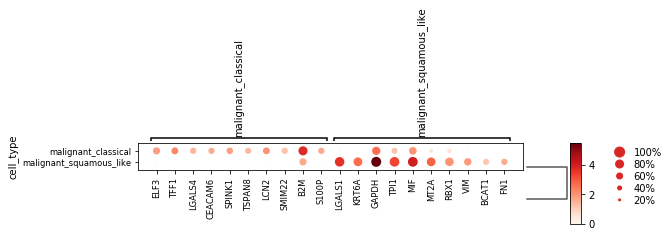

In [24]:
sc.pl.rank_genes_groups_dotplot(tumor)

In [25]:
list(tumor.uns.keys())

['leiden',
 'neighbors',
 'pca',
 'rank_genes_groups',
 'sample_id_colors',
 'umap',
 'dendrogram_cell_type']

In [27]:
tumor.uns['rank_genes_groups']['names']['malignant_squamous_like']

array(['LGALS1', 'KRT6A', 'GAPDH', 'TPI1', 'MIF', 'MT2A', 'RBX1', 'VIM',
       'BCAT1', 'FN1', 'EMP3', 'MRPL51', 'MIA', 'RNASE1', 'MRPL52',
       'RBP1', 'NPC2', 'TMSB4X', 'UQCR10', 'SEC61G', 'TRBC2', 'TNNT1',
       'TMSB10', 'SERPINF1', 'ROMO1', 'LCP1', 'CSTB', 'LDHB', 'PFN2',
       'ENO1', 'COL6A2', 'S100A16', 'OST4', 'S100A13', 'MIR4435-2HG',
       'PODXL', 'HMGA2', 'NEDD8', 'FTL', 'C4orf3', 'STC2', 'KRT5',
       'RPL26', 'PGAM1', 'SLC2A3', 'ARL4C', 'COL6A1', 'PHB2', 'COL6A3',
       'SLIRP', 'SRGN', 'RPL38', 'STMN1', 'RPLP0', 'IGFBP6', 'RPLP1',
       'ITGAE', 'S100A4', 'LSM1', 'PKM', 'PSMB6', 'SNU13', 'RPS26',
       'STRAP', 'NDUFA6', 'WIPF1', 'IFI27', 'CALD1', 'TOMM22', 'DMKN',
       'TXNDC17', 'STMN3', 'YWHAE', 'NDUFB2', 'LETM2', 'FKBP3', 'PGK1',
       'SERPINE2', 'AKR1B1', 'BRK1', 'TRAPPC1', 'RPL17', 'POLR2L',
       'RPL37A', 'C12orf57', 'RPL28', 'TUBA1B', 'FRMD6', 'CAV1', 'RPS12',
       'PMP22', 'UBE2L3', 'RPS5', 'MRPL40', 'GOLGA7', 'SPARC', 'TMEM230',
       'SNX6'

In [22]:
thresh_to_squam_genes = {}
for thresh in [10, 20, 50, 100, 500, 1000]:
    top_squam = tumor.uns['rank_genes_groups']['names']['Squamous-like'][:thresh]
    thresh_to_squam_genes[thresh] = top_squam

In [23]:
thresh_to_ed_genes = {}
for thresh in [10, 20, 50, 100, 500, 1000]:
    top_ed = np.asarray(tumor.var['cytotrace_correlation'].sort_values(ascending=False).index[:thresh])
    thresh_to_ed_genes[thresh] = top_ed

In [24]:
adata.obs['ductal_subtype'] = [tumor.obs.loc[c, 'ductal_subtype'] if c in tumor.obs.index else np.nan
                              for c in adata.obs.index]
adata.var['cytotrace_correlation'] = [tumor.var.loc[g, 'cytotrace_correlation']
                                     for g in adata.var.index]

In [25]:
for thresh, genes in thresh_to_squam_genes.items():
    adata.uns[f'top_{thresh}_squam'] = genes
for thresh, genes in thresh_to_ed_genes.items():
    adata.uns[f'top_{thresh}_ed'] = genes

In [26]:
adata.write_h5ad('../results/cytotrace/eus_adata_step3.h5ad')

... storing 'ductal_subtype' as categorical


In [ ]:
tumor.var['cytotrace_correlation'].sort_values(ascending=False).index[:20]